In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Define the CNN architecture
class CFD_CNN(nn.Module):
    def __init__(self):
        super(CFD_CNN, self).__init__()
        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Fully connected layer to reduce dimensionality
        self.fc1 = nn.Linear(256 * 32 * 32, 1024)  # Assuming input size 32x32
        self.fc2 = nn.Linear(1024, 256 * 32 * 32)
        
        # Decoding layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=3, stride=1, padding=1),  # Output has 2 channels for velocity components
        )

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 256, 32, 32)  # Reshape for decoding

        # Decoding
        x = self.decoder(x)
        return x


In [5]:
def sdf_circle(center, radius, grid):
    """Generate Signed Distance Function for a circle."""
    cx, cy = center
    x, y = np.meshgrid(np.arange(grid), np.arange(grid))
    sdf = np.sqrt((x - cx)**2 + (y - cy)**2) - radius
    return sdf

def sdf_rectangle(center, width, height, grid):
    """Generate Signed Distance Function for a rectangle."""
    cx, cy = center
    x, y = np.meshgrid(np.arange(grid), np.arange(grid))
    dx = np.maximum(np.abs(x - cx) - width / 2, 0)
    dy = np.maximum(np.abs(y - cy) - height / 2, 0)
    sdf = np.sqrt(dx**2 + dy**2)
    sdf = np.where(np.abs(x - cx) <= width / 2, np.maximum(dy, 0), sdf)
    sdf = np.where(np.abs(y - cy) <= height / 2, np.maximum(dx, 0), sdf)
    return sdf

def sdf_triangle(vertices, grid):
    """Generate Signed Distance Function for a triangle."""
    x, y = np.meshgrid(np.arange(grid), np.arange(grid))
    v0, v1, v2 = vertices
    
    def edge_sdf(px, py, ax, ay, bx, by):
        pa_x, pa_y = px - ax, py - ay
        ba_x, ba_y = bx - ax, by - ay
        h = np.clip((pa_x * ba_x + pa_y * ba_y) / (ba_x**2 + ba_y**2), 0, 1)
        return np.sqrt((pa_x - h * ba_x)**2 + (pa_y - h * ba_y)**2)
    
    sdf0 = edge_sdf(x, y, *v0, *v1)
    sdf1 = edge_sdf(x, y, *v1, *v2)
    sdf2 = edge_sdf(x, y, *v2, *v0)
    
    sign0 = (x - v0[0]) * (v1[1] - v0[1]) - (y - v0[1]) * (v1[0] - v0[0]) < 0
    sign1 = (x - v1[0]) * (v2[1] - v1[1]) - (y - v1[1]) * (v2[0] - v1[0]) < 0
    sign2 = (x - v2[0]) * (v0[1] - v2[1]) - (y - v2[1]) * (v0[0] - v2[0]) < 0
    
    sdf = np.minimum(np.minimum(sdf0, sdf1), sdf2)
    sdf[sign0 == sign1] = -sdf[sign0 == sign1]
    sdf[sign1 == sign2] = -sdf[sign1 == sign2]
    return sdf

def generate_dataset(grid_size=32, num_samples=100):
    """Generate a dataset of SDFs for different shapes."""
    dataset = []
    labels = []
    
    for _ in range(num_samples):
        shape_type = np.random.choice(['circle', 'rectangle', 'triangle'])
        if shape_type == 'circle':
            radius = np.random.uniform(5, 12)
            center = np.random.uniform(radius, grid_size - radius, 2)
            sdf = sdf_circle(center, radius, grid_size)
        elif shape_type == 'rectangle':
            width = np.random.uniform(5, 12)
            height = np.random.uniform(5, 12)
            center = np.random.uniform(max(width, height) / 2, grid_size - max(width, height) / 2, 2)
            sdf = sdf_rectangle(center, width, height, grid_size)
        elif shape_type == 'triangle':
            vertices = np.random.uniform(5, grid_size - 5, (3, 2))
            sdf = sdf_triangle(vertices, grid_size)
        
        dataset.append(sdf)
        labels.append(shape_type)
    
    return np.array(dataset), np.array(labels)

# Generate the dataset
dataset, labels = generate_dataset()
tensor_dataset = torch.tensor(dataset).unsqueeze(1).float()


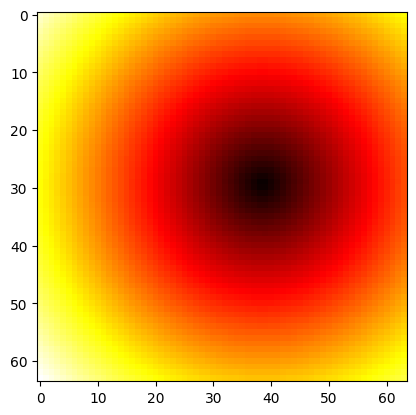

<built-in method type of Tensor object at 0x1240afb30>


In [5]:
plt.imshow(tensor_dataset[0][0], cmap='hot', interpolation='nearest')
plt.show()
print(tensor_dataset[0][0].type)

In [6]:
# Initialize the model, loss function, and optimizer
model = CFD_CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_tensor = tensor_dataset 
# input_tensor = torch.randn((10, 1, 32, 32))  # Example batch of 10, 32x32 grid

# Forward pass
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Should be (10, 2, 32, 32) for 2D velocity components

print(input_tensor.type)

torch.Size([100, 2, 32, 32])
<built-in method type of Tensor object at 0x127ef3b90>


In [44]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(input_tensor)
    loss = criterion(outputs, input_tensor)  # Assuming input_tensor contains the target velocities for simplicity
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 1, 32, 32])) that is different to the input size (torch.Size([100, 2, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 107.5663
Epoch [2/10], Loss: 29458.8828


KeyboardInterrupt: 